# CSE 598 Machine Learning Security and Fairness
## Assignment 2: Train and Attack Classifier
### Sumedh Shridhar Joshi
### ASU Id: 1225507023 

#### Task 1: Train a Fashion-MNIST Classifier

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models, utils
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import torchvision.utils

In [4]:
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 16

In [5]:
# Load the dataset and train, val, test splits
print("Loading datasets...")
FASHION_transform = transforms.Compose([
    transforms.ToTensor(), # Transform from [0,255] uint8 to [0,1] float
])
FASHION_trainval = datasets.FashionMNIST('.', download=True, train=True, transform=FASHION_transform)
FASHION_train = Subset(FASHION_trainval, range(50000))
FASHION_val = Subset(FASHION_trainval, range(50000,60000))
FASHION_test = datasets.FashionMNIST('.', download=True, train=False, transform=FASHION_transform)
print("Done!")

# Create dataloaders
trainloader = DataLoader(FASHION_train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(FASHION_val, batch_size=batch_size, shuffle=True)
testloader = DataLoader(FASHION_test, batch_size=batch_size, shuffle=True)

Loading datasets...


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Done!


In [6]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)


    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
model = Network().to(device)
criterion = nn.CrossEntropyLoss()

In [9]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
num_epoch = num_epochs

In [10]:
def train(model, loader, num_epoch = num_epochs):
    print("Start training...")
    model.train()
    for i in range(num_epoch):
        running_loss = []
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad() # To clear gradients from the iteration prior to this.
            pred = model(batch)
            loss = criterion(pred, label) # Calculate the loss.
            running_loss.append(loss.item())
            loss.backward() # Backprop gradients to all tensors in the network
            optimizer.step() # Update weights
        print("Epoch {} loss:{}".format(i+1,np.mean(running_loss)))
    print("Done!")

In [11]:
def evaluate(model, loader): # Evaluate accuracy on validation / test set
    model.eval() # Set the model to evaluation mode
    correct = 0
    with torch.no_grad():
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
    acc = correct/len(loader.dataset)
    print("\nEvaluation accuracy: {}".format(acc))
    return acc

In [13]:
train(model, trainloader, num_epochs)

Start training...


100%|██████████| 782/782 [00:07<00:00, 100.25it/s]


Epoch 1 loss:0.12630495678542938


100%|██████████| 782/782 [00:07<00:00, 99.93it/s] 


Epoch 2 loss:0.12064256256951204


100%|██████████| 782/782 [00:07<00:00, 99.83it/s]


Epoch 3 loss:0.11408105815577385


100%|██████████| 782/782 [00:07<00:00, 99.25it/s]


Epoch 4 loss:0.10895458291239483


100%|██████████| 782/782 [00:07<00:00, 100.55it/s]


Epoch 5 loss:0.10903905794176909


100%|██████████| 782/782 [00:07<00:00, 100.40it/s]


Epoch 6 loss:0.1020382638887295


100%|██████████| 782/782 [00:07<00:00, 99.24it/s]


Epoch 7 loss:0.09762688828132036


100%|██████████| 782/782 [00:07<00:00, 99.25it/s] 


Epoch 8 loss:0.09532921037474729


100%|██████████| 782/782 [00:07<00:00, 99.49it/s]


Epoch 9 loss:0.09350026641612696


100%|██████████| 782/782 [00:07<00:00, 99.43it/s]


Epoch 10 loss:0.09148481799780256


100%|██████████| 782/782 [00:07<00:00, 98.86it/s]


Epoch 11 loss:0.0850722438720105


100%|██████████| 782/782 [00:07<00:00, 98.04it/s]


Epoch 12 loss:0.08402421737275541


100%|██████████| 782/782 [00:07<00:00, 99.91it/s]


Epoch 13 loss:0.08294755520889788


100%|██████████| 782/782 [00:07<00:00, 98.82it/s] 


Epoch 14 loss:0.07996901225767877


100%|██████████| 782/782 [00:07<00:00, 98.89it/s] 


Epoch 15 loss:0.07591569644120305


100%|██████████| 782/782 [00:07<00:00, 98.65it/s]

Epoch 16 loss:0.07700332958201218
Done!


In [14]:
print("Evaluation on Val Set... ")
evaluate(model, valloader)

Evaluation on Val Set... 


100%|██████████| 157/157 [00:01<00:00, 141.77it/s]


Evaluation accuracy: 0.9105


0.9105

In [15]:
print("Evaluation on Test Set... ")
evaluate(model, testloader)

Evaluation on Test Set... 


100%|██████████| 157/157 [00:01<00:00, 142.82it/s]


Evaluation accuracy: 0.9023


0.9023

In [16]:
model_save_name = 'classifier_9078.pt'
path = F"/content/gdrive/MyDrive/CSE: 598 Machine Learning Security and Fairness Assignment 1/{model_save_name}" 
torch.save(model, path)

### Task 2: Implement attacks for the Fashion-MNIST Classification

Problem Statement 1: Implement a non-targeted white-box FGSM evasion attack against the deep learning model from Task 1. Applying the perturbation magnitude as 25/255 (𝝐 = 25/255).

In [17]:
model = torch.load(path)
model.eval()

Network(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [18]:
epsilon = 25/255
accurate_pred_output_before_attack = 0
wrong_pred_output_after_attack = 0
iteration_wise_accuracy = []

In [19]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain range between [0,1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [20]:
def testFGSM(model, device, test_loader, epsilon):

  # Accuracy counter
	wrong_pred_output_after_attack = 0
	accurate_pred_output_before_attack = 0
	adv_examples = []

  # Loop over all examples in test set
	for data, target in tqdm(test_loader):
		# Send the data and label to the device
		data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
		data.requires_grad = True

        # Forward pass the data through the model
		output = model(data)
		init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
		if init_pred.item() != target.item():
			continue
		accurate_pred_output_before_attack+=1	
        
        # Calculate the loss
		loss = F.nll_loss(output, target)
        
        # Zero all existing gradients
		model.zero_grad()
        
        # Calculate gradients of model in backward pass
		loss.backward()
        
        # Collect datagrad
		data_grad = data.grad.data
    	
      # Call FGSM Attack
		perturbed_data = fgsm_attack(data, epsilon, data_grad)
		
    # Re-classify the perturbed image
		output = model(perturbed_data)
        
        # Check for success
		final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
		if final_pred.item() != target.item():
			wrong_pred_output_after_attack += 1
	        
          # Adversarial examples for visualization
			if len(adv_examples) < 10:
				adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
				adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    
    # Calculate final accuracy for this epsilon
	final_accuracy = wrong_pred_output_after_attack/float(accurate_pred_output_before_attack)
	print("FGSM Attack\nEpsilon: {}\nAttack Accuracy = (Wrong Pred Labels After Attack) / (Accurate Pred Labels Before Attack) = {} / {} = {}\n\n".format(epsilon, wrong_pred_output_after_attack, accurate_pred_output_before_attack, final_accuracy))

    # Return the accuracy and an adversarial example
	return final_accuracy, adv_examples

Problem Statement 2: Implement a non-targeted white-box PGD evasion attack against the deep learning model from Task 1. Applying the perturbation magnitude as 25/255 (𝝐 = 25/255). Please try to apply different attack steps including {1,2,5,10}

In [21]:
# pgd attack code
def pgd_attack(model, image, label, epsilon, steps=10, alpha=2/255 ) :
	original_image = image            
	for i in range(steps) :    
		image.requires_grad = True
		output = model(image)
		# Calculating loss
		loss = F.nll_loss(output, label)
		# Zero all existing gradients
		model.zero_grad()

		loss.backward()  # Calculate gradients of model in backward pass

	    # Collect datagrad
		data_grad = image.grad.data	

		adv_image = image + alpha*data_grad.sign()
		eta = torch.clamp(adv_image - original_image, min=-epsilon, max=epsilon)
		image = torch.clamp(original_image + eta, min=0, max=1).detach_()
	return image

In [22]:
def test_PGD (model, device, test_loader, epsilon,steps=10) :
    # Accuracy counter
	wrong_pred_output_after_attack = 0
	accurate_pred_output_before_attack = 0
	adv_examples = []

	for data,target in tqdm(test_loader) :
		
    # Send the data and label to the device
		data, target = data.to(device), target.to(device)
        
        # Set requires_grad attribute of tensor. Important for Attack
		data.requires_grad = True

        # Forward pass the data through the model
		output = model(data)
		init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong do not attack
		if init_pred.item() != target.item():
			continue
		accurate_pred_output_before_attack+=1	


		perturbed_data = pgd_attack(model,data.to(device),target.to(device),epsilon,steps)

		# Re-classify the perturbed image
		output = model(perturbed_data)

	    # Check for success
		final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
		if final_pred.item() != target.item():
			wrong_pred_output_after_attack += 1
		    # Save some adv examples for visualization later
			if len(adv_examples) < 10:
				adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
				adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
	final_accuracy = wrong_pred_output_after_attack/float(accurate_pred_output_before_attack)
	print("\nSteps: {}\nAttack Accuracy = (Wrong Pred Labels After Attack) / (Accurate Pred Labels Before Attack) = {} / {} = {}\n\n".format(epsilon, wrong_pred_output_after_attack, accurate_pred_output_before_attack, final_accuracy))

	iteration_wise_accuracy.append(final_accuracy)
    # Return the accuracy and an adversarial example
	return final_accuracy, adv_examples

In [23]:
def show_adversarial_images(examples,labels) :
	cnt = 0
	for j in range(len(examples)):
		cnt+=1
		plt.xticks([], [])
		plt.yticks([], [])
		orig,adv,ex = examples[j]
		plt.title("{} -> {}".format(labels[orig],labels[adv]))
		plt.imshow(ex, cmap="gray")
		plt.tight_layout()
		plt.show()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

cuda


100%|██████████| 10000/10000 [00:30<00:00, 325.64it/s]


FGSM Attack
Epsilon: 0.09803921568627451
Attack Accuracy = (Wrong Pred Labels After Attack) / (Accurate Pred Labels Before Attack) = 8309 / 9023 = 0.9208688906128782


PGD Attack


100%|██████████| 10000/10000 [00:37<00:00, 268.57it/s]



Steps: 0.09803921568627451
Attack Accuracy = (Wrong Pred Labels After Attack) / (Accurate Pred Labels Before Attack) = 1795 / 9023 = 0.1989360523107614




100%|██████████| 10000/10000 [00:56<00:00, 175.79it/s]



Steps: 0.09803921568627451
Attack Accuracy = (Wrong Pred Labels After Attack) / (Accurate Pred Labels Before Attack) = 3680 / 9023 = 0.4078466142081348




100%|██████████| 10000/10000 [01:55<00:00, 86.79it/s]



Steps: 0.09803921568627451
Attack Accuracy = (Wrong Pred Labels After Attack) / (Accurate Pred Labels Before Attack) = 7278 / 9023 = 0.806605341904023




100%|██████████| 10000/10000 [03:33<00:00, 46.73it/s]



Steps: 0.09803921568627451
Attack Accuracy = (Wrong Pred Labels After Attack) / (Accurate Pred Labels Before Attack) = 9008 / 9023 = 0.9983375817355646




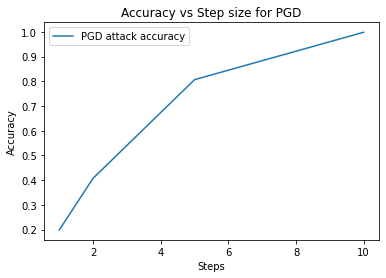

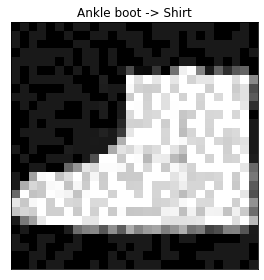

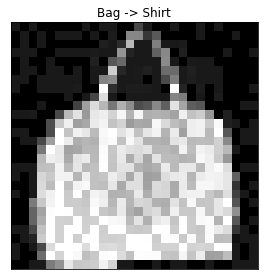

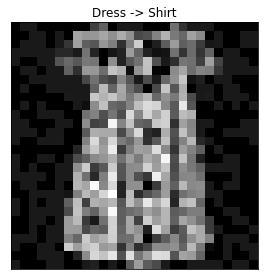

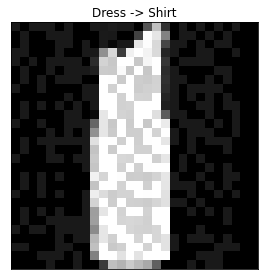

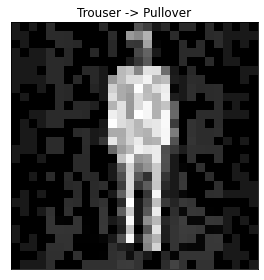

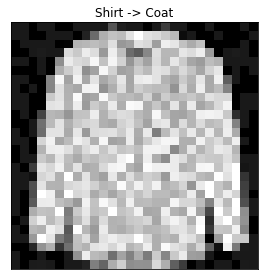

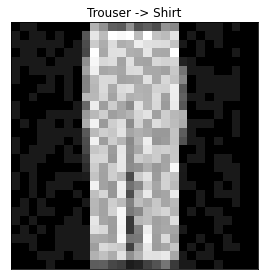

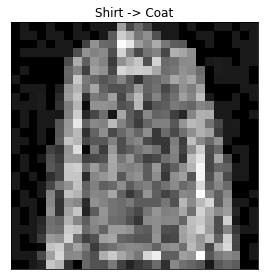

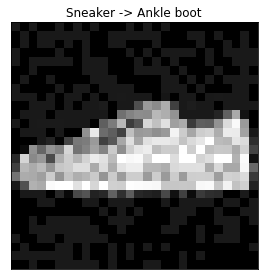

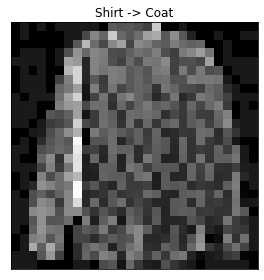

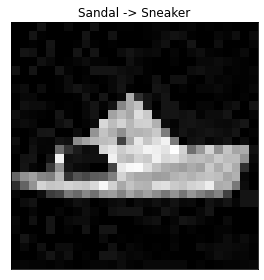

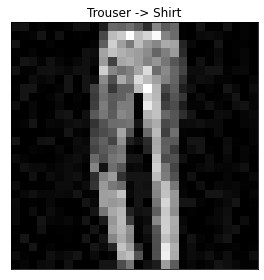

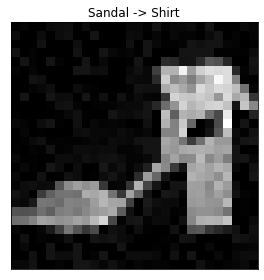

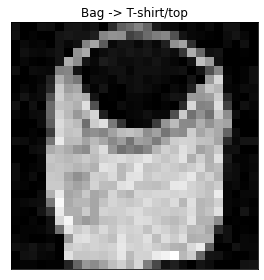

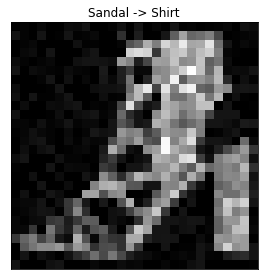

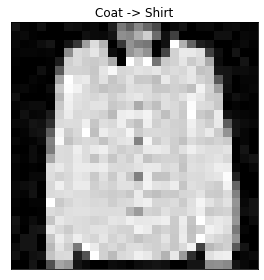

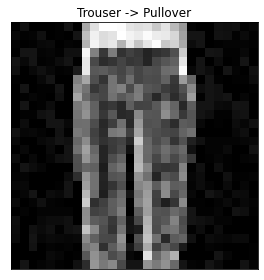

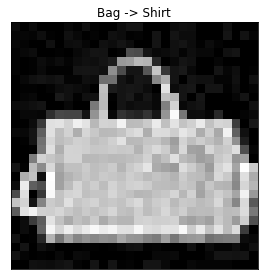

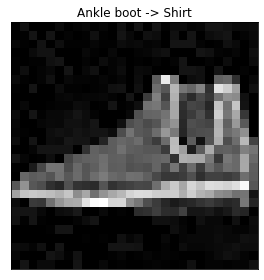

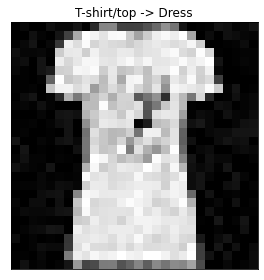

In [24]:
def show_step_wise_plot(iteration_wise_accuracy,steps) :
    y = iteration_wise_accuracy
    x = steps
    plt.title('Accuracy vs Step size for PGD')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')    
    plt.plot(x,y)
    plt.legend(['PGD attack accuracy', 'steps'])
    plt.show()


# Loading again to with batch size 1
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)


device = "cuda" if torch.cuda.is_available() else "cpu" # Configure device
print(device)

model = Network().to(device)
model = torch.load(path)
model.eval()

accuracies = []
examples = []

acc_FGSM, ex_FGSM = testFGSM(model, device, test_loader, epsilon)

steps_array = [1,2,5,10]
print("PGD Attack")  
for steps in steps_array:
	acc_PGD, ex_PGD = test_PGD(model, device, test_loader, epsilon, steps)


labels = { 0: 'T-shirt/top', 1: 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat' , 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker' , 8 : 'Bag' , 9 : 'Ankle boot'}
show_step_wise_plot(iteration_wise_accuracy,steps_array)

show_adversarial_images(ex_FGSM,labels)
show_adversarial_images(ex_PGD,labels)